Dataset loaded successfully!
Shape: (918, 12)
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Removed 19 outliers. New shape: (899, 12)

--- Model Accuracies Before PCA ---
SVM: 0.8889
              precision    recall  f1-score   support

           0  

/tmp/ipython-input-3936504065.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[col] = le.fit_transform(df_clean[col])


Random Forest: 0.8944
              precision    recall  f1-score   support

           0       0.99      0.79      0.88        86
           1       0.84      0.99      0.91        94

    accuracy                           0.89       180
   macro avg       0.91      0.89      0.89       180
weighted avg       0.91      0.89      0.89       180


PCA reduced features from 15 to 13

--- Model Accuracies After PCA ---
SVM: 0.8889
              precision    recall  f1-score   support

           0       0.99      0.78      0.87        86
           1       0.83      0.99      0.90        94

    accuracy                           0.89       180
   macro avg       0.91      0.88      0.89       180
weighted avg       0.90      0.89      0.89       180

Logistic Regression: 0.8889
              precision    recall  f1-score   support

           0       0.96      0.80      0.87        86
           1       0.84      0.97      0.90        94

    accuracy                           0.89     

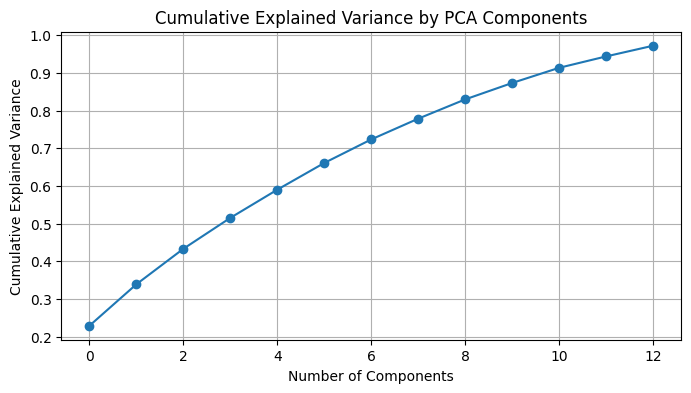

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt


df = pd.read_csv("heart.csv")
print("Dataset loaded successfully!")
print("Shape:", df.shape)
print(df.head())

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
z_scores = np.abs(stats.zscore(df[numeric_cols]))
df_clean = df[(z_scores < 3).all(axis=1)]
print(f"\nRemoved {len(df) - len(df_clean)} outliers. New shape: {df_clean.shape}")


object_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()
le = LabelEncoder()
for col in object_cols:
    if df_clean[col].nunique() == 2:
        df_clean[col] = le.fit_transform(df_clean[col])
    else:
        df_clean = pd.get_dummies(df_clean, columns=[col], drop_first=True)


target_col = 'HeartDisease' if 'HeartDisease' in df_clean.columns else df_clean.columns[-1]
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "SVM": SVC(kernel='rbf', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

print("\n--- Model Accuracies Before PCA ---")
results_before = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results_before[name] = acc
    print(f"{name}: {acc:.4f}")
    print(classification_report(y_test, y_pred))


pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"\nPCA reduced features from {X_scaled.shape[1]} to {X_pca.shape[1]}")

Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


print("\n--- Model Accuracies After PCA ---")
results_after = {}
for name, model in models.items():
    model.fit(Xp_train, yp_train)
    y_pred = model.predict(Xp_test)
    acc = accuracy_score(yp_test, y_pred)
    results_after[name] = acc
    print(f"{name}: {acc:.4f}")
    print(classification_report(yp_test, y_pred))


print("\n--- Model Comparison (Before vs After PCA) ---")
for name in models.keys():
    print(f"{name}: Before PCA = {results_before[name]:.4f}, After PCA = {results_after[name]:.4f}")


plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()
